In [2]:
import numpy as np
from skimage import data, io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
from statistics import mode
import time

In [9]:
Ig = io.imread("projetstereo/cones/im2.png")
Id = io.imread("projetstereo/cones/im6.png")

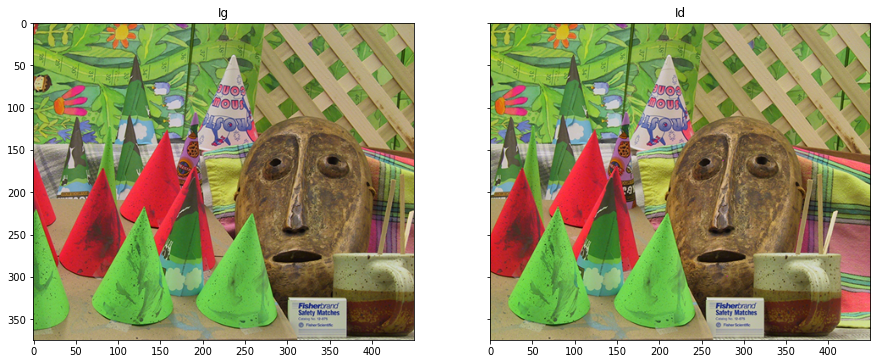

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15), sharex=True, sharey=True)
axes[0].imshow(Ig)
axes[0].set_title("Ig")
axes[1].imshow(Id)
axes[1].set_title("Id")
plt.show()

In [11]:
Iggray = (rgb2gray(Ig)*255).astype("uint8")
Idgray = (rgb2gray(Id)*255).astype("uint8")

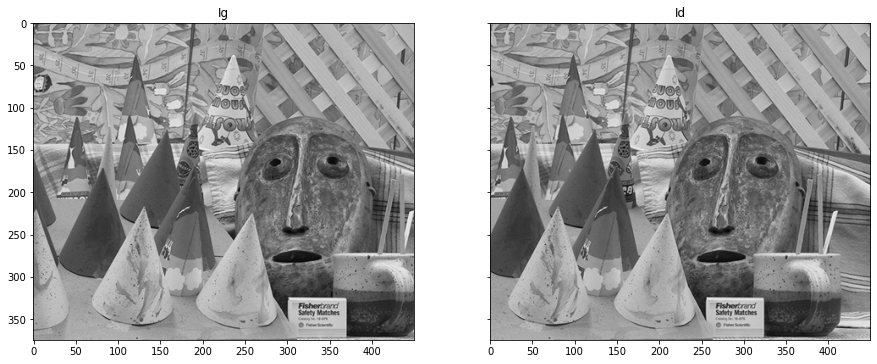

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15), sharex=True, sharey=True)
axes[0].imshow(Iggray, cmap="gray")
axes[0].set_title("Ig")
axes[1].imshow(Idgray, cmap="gray")
axes[1].set_title("Id")
plt.show()

# Block matching algorithm and perfomance

## Using only numpy objects : 1min25s

In [13]:
def get_dissimilarity(left_image, right_image, left_pixel_considered, right_pixel_considered, neighbourhood):
    """ 
    Return the dissimilarity between 2 parts (2 matrices) of 2 images.
    The dissimilarity is calculated according to the SAD formula.
    
    Args:
        left_image(np.ndarray): 2D array representing an image in gray.
        right_image(np.ndarray): 2D array representing an image in gray.
        left_pixel_considered(tuple): coordinates of the left pixel considered as center
            of the first matrix from left image.
        right_pixel_considered(tuple): coordinates of the left pixel considered as center
            of the first matrix from right image.
        neighbourhood(int): number of pixels considered in the neighbourhood for SAD formula.
        
    Returns:
        dissimilarity(int): dissimilarity calculated between the 2 parts.
    """
    
    dissimilarity = np.sum(
        np.abs(
            np.subtract(
                left_image[
                    left_pixel_considered[0]-neighbourhood//2:left_pixel_considered[0]+neighbourhood//2+1,
                    left_pixel_considered[1]-neighbourhood//2:left_pixel_considered[1]+neighbourhood//2+1
                ].astype("int"),
                right_image[
                    right_pixel_considered[0]-neighbourhood//2:right_pixel_considered[0]+neighbourhood//2+1,
                    right_pixel_considered[1]-neighbourhood//2:right_pixel_considered[1]+neighbourhood//2+1
                ].astype("int")
            ) 
        )
    )
    
    return dissimilarity

In [14]:
def get_disparity(left_image, right_image, left_pixel_considered, neighbourhood, maxdisp, order):
    """
    Get the disparity for one point in the left image to his conjugated in the right image.
    
    Args:
        left_image(np.ndarray): 2D array representing an image in gray.
        right_image(np.ndarray): 2D array representing an image in gray.
        left_pixel_considered(tuple): coordinates of a point in left_image we want to
            get his disparity with the right image.
        neighbourhood(int): number of pixels considered in the neighbourhood for SAD formula.
        maxdisp(int): max disparity observed between the 2 images.
        order(string): oreder of the movement. Choice between left and right.
        
    Returns:
        disparity(int): disparity of the left_point_considered with the right image.
    """
    
    min_dissimilarity = get_dissimilarity(
        left_image,
        right_image,
        left_pixel_considered,
        left_pixel_considered, 
        neighbourhood
    )
    
    disparity = 0
    ranges = np.arange(1, maxdisp)
    for i in range(1, maxdisp):
        if order == "left":
            dissimilarity = get_dissimilarity(
                left_image,
                right_image,
                left_pixel_considered,
                (left_pixel_considered[0], left_pixel_considered[1]-i),
                neighbourhood
            )
        elif order == "right":
            dissimilarity = get_dissimilarity(
                left_image,
                right_image,
                left_pixel_considered,
                (left_pixel_considered[0], left_pixel_considered[1]+i),
                neighbourhood
            )
        if dissimilarity < min_dissimilarity:
            min_dissimilarity = dissimilarity
            disparity = i
            
    return disparity

In [15]:
def get_disparity_map(left_image, right_image, neighbourhood, maxdisp, order):
    """
    Get the disparity map between 2 images
    
    Args:
        left_image(np.ndarray): 2D array representing an image in gray.
        right_image(np.ndarray): 2D array representing an image in gray.
        neighbourhood(int): number of pixels considered in the neighbourhood for SAD formula.
        maxdisp(int): max disparity observed between the 2 images.
        order(string): oreder of the movement. Choice between left and right.
    
    Returns:
        disparity_map(np.ndarray): disparity map between the 2 images
    """
    
    disparity_map = np.zeros(left_image.shape)
    if order == "left":
        for row in range(neighbourhood, disparity_map.shape[0]-neighbourhood):
            for col in range(maxdisp+neighbourhood, disparity_map.shape[1]-neighbourhood):
                disparity_map[row, col] = get_disparity(
                    left_image,
                    right_image,
                    (row, col),
                    neighbourhood,
                    maxdisp,
                    order
                )
    elif order == "right":
        for row in range(neighbourhood, disparity_map.shape[0]-neighbourhood):
            for col in range(neighbourhood, disparity_map.shape[1]-maxdisp-neighbourhood):
                disparity_map[row, col] = get_disparity(
                    left_image,
                    right_image,
                    (row, col),
                    neighbourhood,
                    maxdisp,
                    order
                )
    
    return disparity_map

--- 84.56692790985107 seconds ---






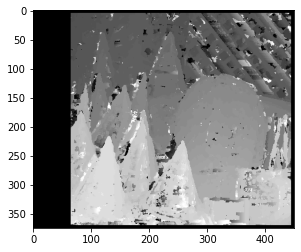

In [16]:
start_time = time.time()
test = get_disparity_map(Iggray, Idgray, 5, 60, "left")
print("--- %s seconds ---" % (time.time() - start_time))
print()
print()
print()
print()
plt.imshow(test, cmap="gray")

## Using both numpy objects and python lists : 58s

In [17]:
def get_dissimilarity_numpy_and_list(left_list, right_list):
    dissimilarity = 0
    
    for sublist in range(len(left_list)):
        for element in range(len(left_list[sublist])):
            dissimilarity += abs(left_list[sublist][element] - right_list[sublist][element])
    
    return dissimilarity

In [18]:
def get_disparity_numpy_and_list(left_image, right_image, left_pixel_considered, neighbourhood, maxdisp, order):
    left_matrix = left_image[
        left_pixel_considered[0]-neighbourhood//2:left_pixel_considered[0]+neighbourhood//2+1,
        left_pixel_considered[1]-neighbourhood//2:left_pixel_considered[1]+neighbourhood//2+1
    ].astype("int").tolist()
    first_right_matrix = right_image[
        left_pixel_considered[0]-neighbourhood//2:left_pixel_considered[0]+neighbourhood//2+1,
        left_pixel_considered[1]-neighbourhood//2:left_pixel_considered[1]+neighbourhood//2+1
    ].astype("int").tolist()
    
    min_dissimilarity = get_dissimilarity_numpy_and_list(left_matrix, first_right_matrix)
    disparity = 0
    for i in range(1, maxdisp):
        right_matrix = right_image[
            left_pixel_considered[0]-neighbourhood//2:left_pixel_considered[0]+neighbourhood//2+1,
            left_pixel_considered[1]-neighbourhood//2-i:left_pixel_considered[1]+neighbourhood//2+1-i
        ].tolist()
        dissimilarity = get_dissimilarity_numpy_and_list(left_matrix, right_matrix)
        
        if dissimilarity < min_dissimilarity:
            min_dissimilarity=dissimilarity
            disparity=i
    return disparity

In [19]:
def get_disparity_map_numpy_and_list(left_image, right_image, neighbourhood, maxdisp, order):
    """
    Get the disparity map between 2 images
    
    Args:
        left_image(np.ndarray): 2D array representing an image in gray.
        right_image(np.ndarray): 2D array representing an image in gray.
        neighbourhood(int): number of pixels considered in the neighbourhood for SAD formula.
        maxdisp(int): max disparity observed between the 2 images.
        order(string): oreder of the movement. Choice between left and right.
    
    Returns:
        disparity_map(np.ndarray): disparity map between the 2 images
    """
    
    disparity_map = np.zeros(left_image.shape)
    if order == "left":
        for row in range(neighbourhood, disparity_map.shape[0]-neighbourhood):
            for col in range(maxdisp+neighbourhood, disparity_map.shape[1]-neighbourhood):
                disparity_map[row, col] = get_disparity_numpy_and_list(
                    left_image,
                    right_image,
                    (row, col),
                    neighbourhood,
                    maxdisp,
                    order
                )
    elif order == "right":
        for row in range(neighbourhood, disparity_map.shape[0]-neighbourhood):
            for col in range(neighbourhood, disparity_map.shape[1]-maxdisp-neighbourhood):
                disparity_map[row, col] = get_disparity_numpy_and_list(
                    left_image,
                    right_image,
                    (row, col),
                    neighbourhood,
                    maxdisp,
                    order
                )
    
    return disparity_map

--- 58.15880012512207 seconds ---






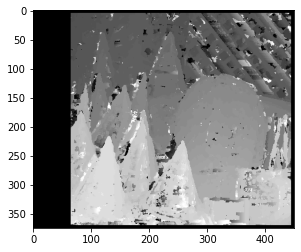

In [20]:
start_time = time.time()
test = get_disparity_map_numpy_and_list(Iggray, Idgray, 5, 60, "left")
print("--- %s seconds ---" % (time.time() - start_time))
print()
print()
print()
print()
plt.imshow(test, cmap="gray")

## Using only python lists : 64s

In [21]:
def get_dissimilarity_list(left_list, right_list):
    dissimilarity = 0
    
    for sublist in range(len(left_list)):
        for element in range(len(left_list[sublist])):
            dissimilarity += abs(left_list[sublist][element] - right_list[sublist][element])
    
    return dissimilarity

In [22]:
def get_disparity_list(left_image, right_image, left_pixel_considered, neighbourhood, maxdisp, order):
    
    left_matrix = [sublist[
        left_pixel_considered[1]-neighbourhood//2:left_pixel_considered[1]+neighbourhood//2+1
        ] for sublist in left_image[
            left_pixel_considered[0]-neighbourhood//2:left_pixel_considered[0]+neighbourhood//2+1
        ]
    ]
    first_right_matrix = [sublist[
        left_pixel_considered[1]-neighbourhood//2:left_pixel_considered[1]+neighbourhood//2+1
        ] for sublist in right_image[
            left_pixel_considered[0]-neighbourhood//2:left_pixel_considered[0]+neighbourhood//2+1
        ]
    ]
    
    min_dissimilarity = get_dissimilarity_list(left_matrix, first_right_matrix)
    disparity = 0
    
    for i in range(1, maxdisp):
        if order == "left":
            right_matrix = [sublist[
                left_pixel_considered[1]-neighbourhood//2-i:left_pixel_considered[1]+neighbourhood//2+1-i
                ] for sublist in right_image[
                    left_pixel_considered[0]-neighbourhood//2:left_pixel_considered[0]+neighbourhood//2+1
                ]
            ]
        elif order == "right":
            right_matrix = [sublist[
                left_pixel_considered[1]-neighbourhood//2+i:left_pixel_considered[1]+neighbourhood//2+1+i
                ] for sublist in right_image[
                    left_pixel_considered[0]-neighbourhood//2:left_pixel_considered[0]+neighbourhood//2+1
                ]
            ]
        dissimilarity = get_dissimilarity_list(left_matrix, right_matrix)
        
        if dissimilarity < min_dissimilarity:
            min_dissimilarity=dissimilarity
            disparity=i
            
    return disparity

In [25]:
def get_disparity_map_list(left_image, right_image, neighbourhood, maxdisp, order):
    """
    Get the disparity map between 2 images
    
    Args:
        left_image(np.ndarray): 2D array representing an image in gray.
        right_image(np.ndarray): 2D array representing an image in gray.
        neighbourhood(int): number of pixels considered in the neighbourhood for SAD formula.
        maxdisp(int): max disparity observed between the 2 images.
        order(string): oreder of the movement. Choice between left and right.
    
    Returns:
        disparity_map(np.ndarray): disparity map between the 2 images
    """
    
    disparity_map = np.zeros(left_image.shape)
    left_image_list = left_image.tolist()
    right_image_list = right_image.tolist()
    if order == "left":
        for row in range(neighbourhood, disparity_map.shape[0]-neighbourhood):
            for col in range(maxdisp+neighbourhood, disparity_map.shape[1]-neighbourhood):
                disparity_map[row, col] = get_disparity_list(
                    left_image_list,
                    right_image_list,
                    (row, col),
                    neighbourhood,
                    maxdisp,
                    order
                )
    elif order == "right":
        for row in range(neighbourhood, disparity_map.shape[0]-neighbourhood):
            for col in range(neighbourhood, disparity_map.shape[1]-maxdisp-neighbourhood):
                disparity_map[row, col] = get_disparity(
                    left_image_list,
                    right_image_list,
                    (row, col),
                    neighbourhood,
                    maxdisp,
                    order
                )
    
    return disparity_map

--- 64.40656614303589 seconds ---






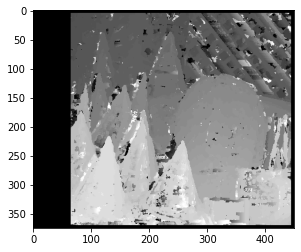

In [26]:
start_time = time.time()
test = get_disparity_map_list(Iggray, Idgray, 5, 60, "left")
print("--- %s seconds ---" % (time.time() - start_time))
print()
print()
print()
print()
plt.imshow(test, cmap="gray")